# Analyzing Re-trained Classifier Performance
### Calum Macdonald
Retrained classifier with best existing config. Ran testing on full test set using resulting weights to attempt to replicate previously presented performance metrics.

In [1]:
import os,sys

currentdir = os.getcwd()
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from utils import plot_utils
import time
import math
import random
import pdb

# Import the utils for plotting the metrics
from plot_utils import notebook_utils_2
from repeating_classifier_training_utils import *

from sklearn.metrics import roc_curve, auc
%matplotlib inline

In [2]:
# Dictionary mapping the ordinal labels to particle types 
LABEL_DICT = {0:"gamma", 1:"e", 2:"mu"}
softmax_index_dict = {value:key for key, value in LABEL_DICT.items()}
label_0 = "e"
label_1 = "mu"
loc = '../dumps/20200506_104330'

## Plotting Training and Validation Loss

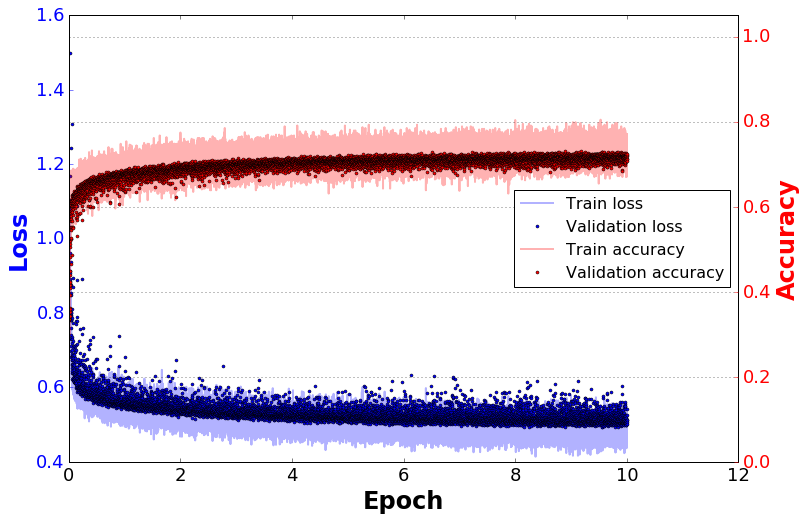

In [3]:
plot_utils.disp_learn_hist(loc)

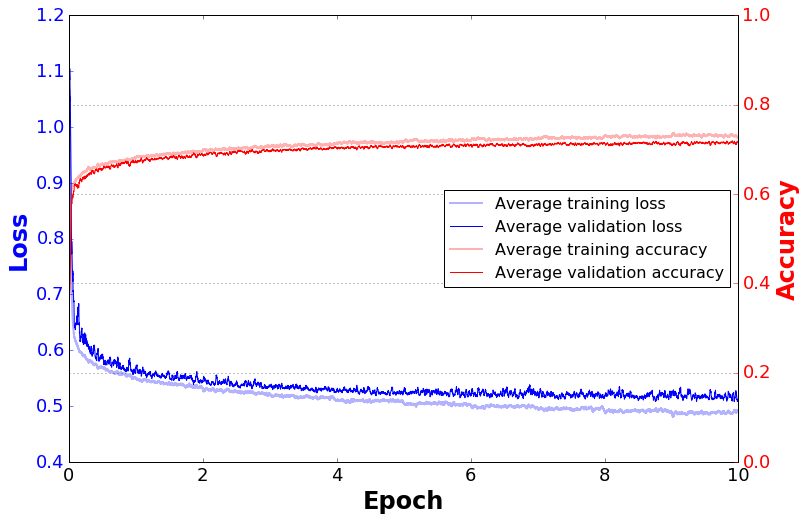

In [4]:
disp_learn_hist_smoothed(loc,window_train=200,window_val=20)

## Plotting Confusion Matrices

In [5]:
# File paths for fiTQun results
fiTQun_e_path = "/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_fiTQun_e-.npz"
fiTQun_mu_path = "/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_fiTQun_mu-.npz"
fiTQun_gamma_path = "/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_fiTQun_gamma.npz"

# Load fiTQun results
f_e = np.load(fiTQun_e_path, allow_pickle=True)
f_mu = np.load(fiTQun_mu_path, allow_pickle=True)
f_gamma = np.load(fiTQun_gamma_path, allow_pickle=True)

e_good_idxs = np.where((f_e['flag'][:,0]==0) & (f_e['flag'][:,1]==0))
m_good_idxs = np.where((f_mu['flag'][:,0]==0) & (f_mu['flag'][:,1]==0))

e_nll = (f_e['nLL'])[e_good_idxs]
m_nll = (f_mu['nLL'])[m_good_idxs]

In [6]:
e_labels = np.zeros(e_nll.shape[0]).astype(int)
m_labels = np.ones(m_nll.shape[0]).astype(int)
e_predictions = np.zeros(e_labels.shape[0]).astype(int)
m_predictions = np.ones(m_labels.shape[0]).astype(int)
e_predictions[np.where(e_nll[:,0]>e_nll[:,1])] = 1
m_predictions[np.where(m_nll[:,0]<m_nll[:,1])] = 0

In [7]:
len(np.where(e_nll[:,0] < e_nll[:,1])[0])/e_nll.shape[0]

0.9384264656775122

In [8]:
len(np.where(m_nll[:,0]>m_nll[:,1])[0])/m_nll.shape[0]

0.9181623663849321

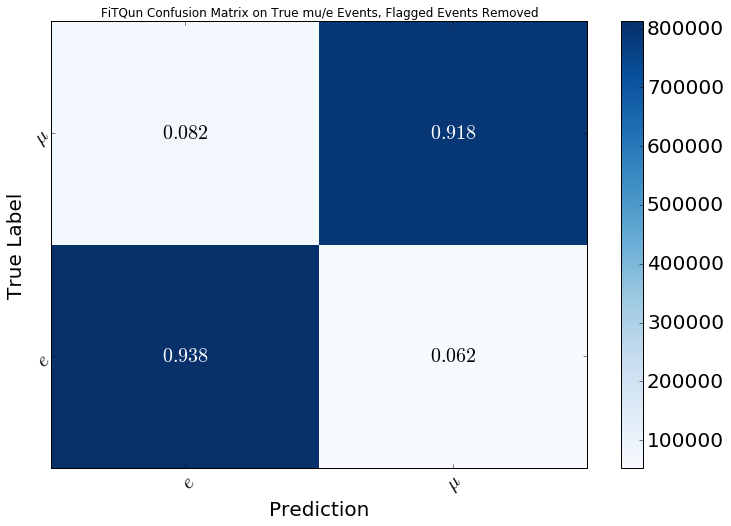

In [9]:
plot_confusion_matrix(np.concatenate((e_labels,m_labels),axis=0),np.concatenate((e_predictions,m_predictions),axis=0),['$e$','$\mu$'],title='FiTQun Confusion Matrix on True mu/e Events, Flagged Events Removed')

In [10]:
res_filtered_data = np.load(os.path.join(os.getcwd(),'resnet_filtered_output.npz'),allow_pickle=True)
res_filtered_predictions = res_filtered_data['res_filtered_predictedlabels']
res_filtered_labels = res_filtered_data['res_filtered_labels']
res_filtered_softmaxes = res_filtered_data['res_filtered_softmaxes']
res_filtered_energies = res_filtered_data['res_filtered_energies']

In [11]:
res_filtered_labels.shape

(2614337,)

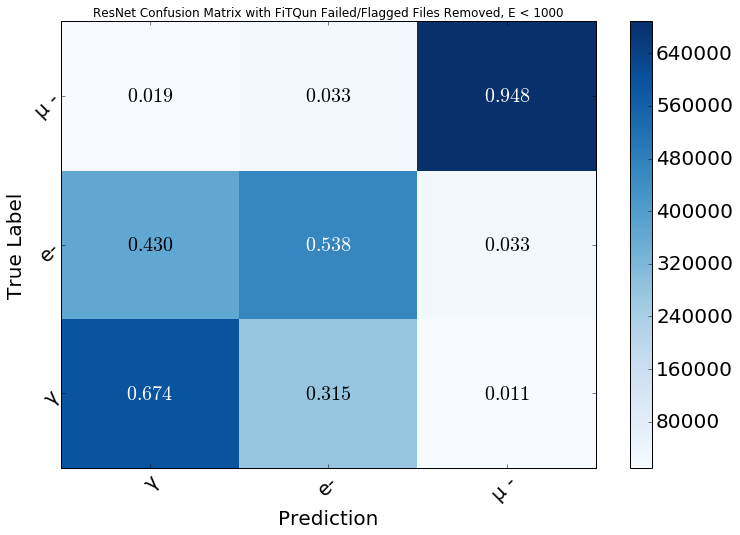

In [12]:
filtered_low_energy_idxs = np.where(res_filtered_energies < 1000)[0]
plot_confusion_matrix(res_filtered_labels[filtered_low_energy_idxs],res_filtered_predictions[filtered_low_energy_idxs],
                      ['\u03B3','e-','\u03BC -'],title='ResNet Confusion Matrix with FiTQun Failed/Flagged Files Removed, E < 1000')

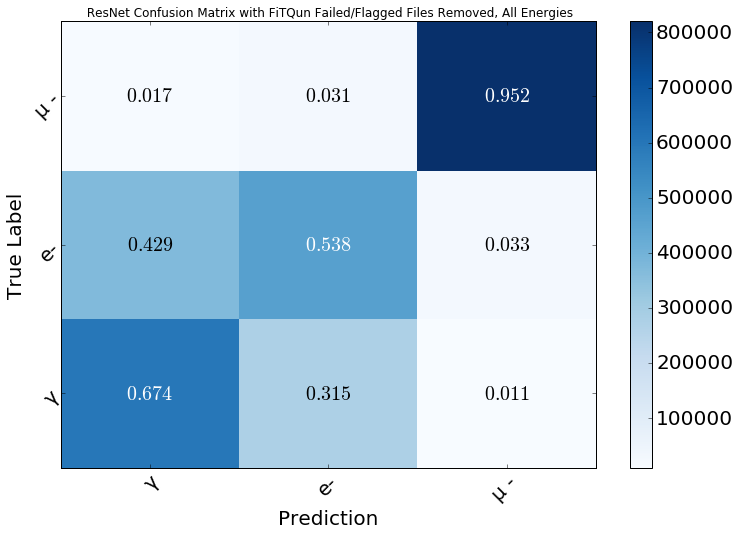

In [13]:
plot_confusion_matrix(res_filtered_labels,res_filtered_predictions,['\u03B3','e-','\u03BC -'],title=' ResNet Confusion Matrix with FiTQun Failed/Flagged Files Removed, All Energies')

In [14]:
test_dump_path = "/home/cmacdonald/CNN/dumps/20200511_151728/test_validation_iteration_dump.npz"
res_original_data = np.load(test_dump_path, allow_pickle=True)

res_predictedlabels = np.concatenate(list([batch_array for batch_array in res_original_data['predicted_labels']]))
res_softmaxes  = np.concatenate(list([batch_array for batch_array in res_original_data['softmax']]))
res_labels   = np.concatenate(list([batch_array for batch_array in res_original_data['labels']]))
res_energies = np.concatenate(list([batch_array for batch_array in res_original_data['energies']]))
res_rootfiles = np.concatenate(list([batch_array for batch_array in res_original_data['rootfiles']]))
res_eventids = np.concatenate(list([batch_array for batch_array in res_original_data['eventids']]))
#res_positions = res_original_data['positions'].reshape(-1)
res_angles = np.concatenate(list([batch_array for batch_array in res_original_data['angles']]))

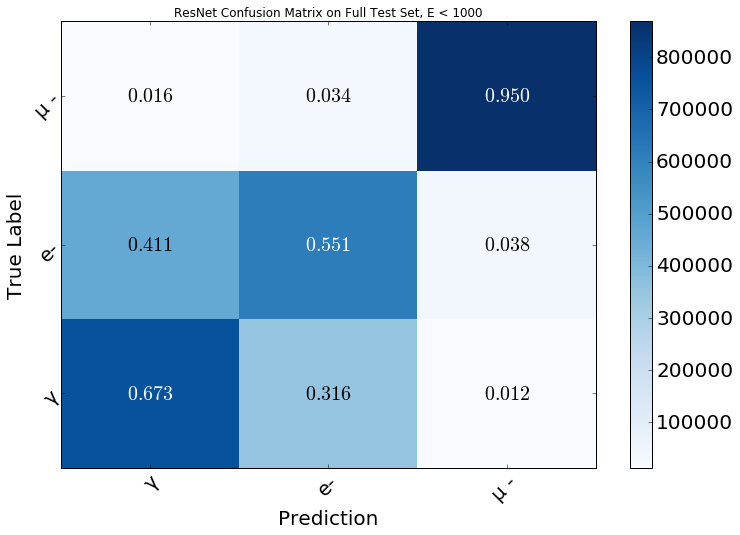

In [15]:
low_energy_idxs = np.where(res_energies < 1000)[0]
plot_confusion_matrix(res_labels[low_energy_idxs],res_predictedlabels[low_energy_idxs],
                      ['\u03B3','e-','\u03BC -'],title='ResNet Confusion Matrix on Full Test Set, E < 1000')

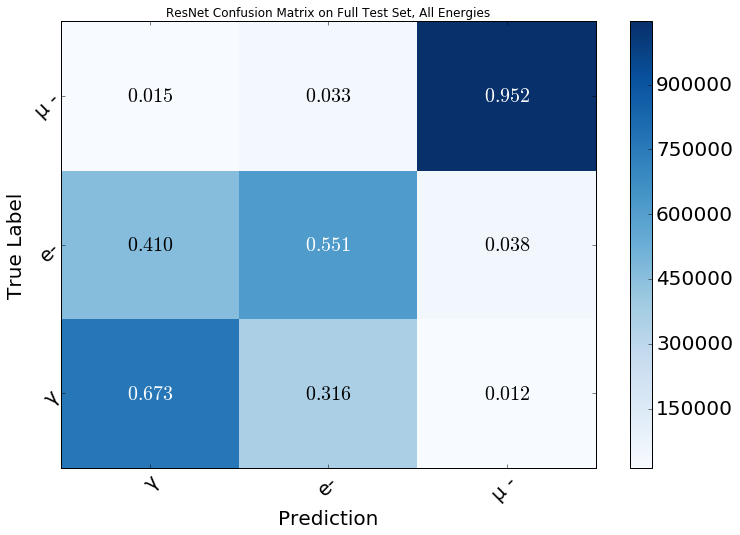

In [16]:
plot_confusion_matrix(res_labels,res_predictedlabels,['\u03B3','e-','\u03BC -'],title='ResNet Confusion Matrix on Full Test Set, All Energies')

## Plotting ROC Curve

In [17]:
res_fpr, res_tpr, res_threshold = prep_roc_data(res_filtered_softmaxes,res_filtered_labels,
                                                res_filtered_energies, softmax_index_dict,
                                                label_0,label_1,threshold=1000
                                                )

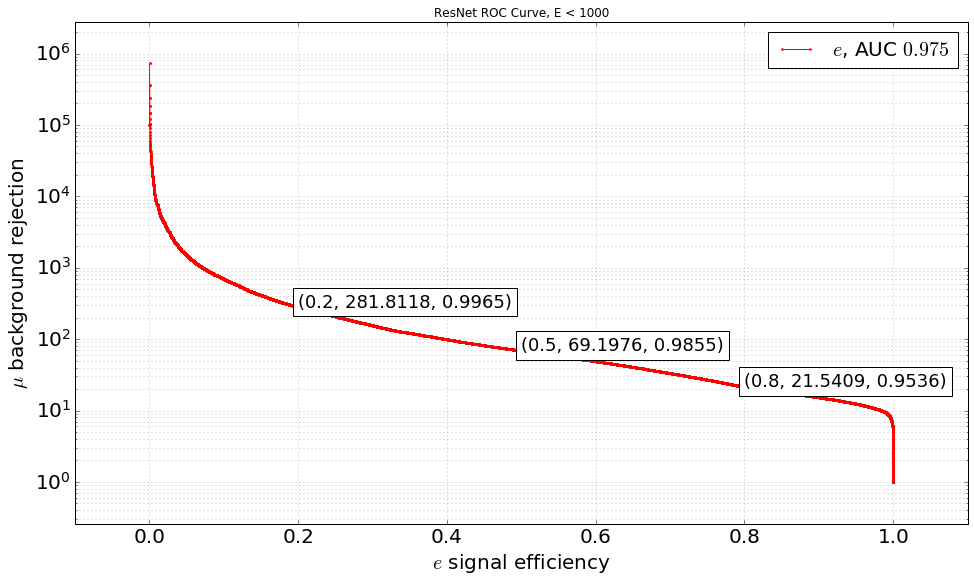

In [18]:
fprs = []
tprs = []
thresholds = []
fprs.append(res_fpr)
tprs.append(res_tpr)
thresholds.append(res_threshold)
roc_metrics = plot_multiple_ROC(fprs, tprs, thresholds, "e", "mu", 0, 1000,png_name = 'thresholded_roc',title='ResNet ROC Curve, E < 1000')